In [1]:
import sqlite3
import pandas as pd
from contextlib import closing

In [12]:
'''
with closing(sqlite3.connect("../db/remote-simulations-sadegh.db")) as connection:
    with closing(connection.cursor()) as cursor:
        rows = cursor.execute("SELECT * from results").fetchall()
        print(rows)
'''
with closing(sqlite3.connect("../db/remote-simulations-sadegh.db")) as connection_sadegh, \
        closing(sqlite3.connect("../db/remote-simulations.db")) as connection_up, \
        closing(sqlite3.connect("../db/remote-simulations-vmware.db")) as connection_vmware:
    sql_query = pd.read_sql_query("SELECT * from results", connection_sadegh)
    results_sadegh = pd.DataFrame(sql_query)
    sql_query = pd.read_sql_query("SELECT * from results", connection_up)
    results_up = pd.DataFrame(sql_query)
    sql_query = pd.read_sql_query("SELECT * from results", connection_vmware)
    results_vmware = pd.DataFrame(sql_query)

    results = pd.concat([results_sadegh, results_up, results_vmware])

results[(results['row_upper_bound'] == 1) & (results['column_upper_bound'] == 1)].head()

,execution_time,experiment_id,window_size,max_nodes,nodes_count,max_services,services_count,dataset,metric_name,metric_value,percentage,row_lower_bound,row_upper_bound,column_lower_bound,column_upper_bound,description,filtering_type
0,23.255926,4,1,7,7,5,5,inmates_enriched_10k,qualitative,0.480067,0.547242,0.6,1.0,0.6,1.0,column and row filtering based on categories,mixed
1,24.591976,7,1,7,7,5,5,inmates_enriched_10k,qualitative,0.391249,0.593650,0.6,1.0,0.6,1.0,column and row filtering based on categories,mixed
2,24.997894,5,1,7,7,5,5,inmates_enriched_10k,qualitative,0.602904,0.420000,0.6,1.0,0.6,1.0,column and row filtering based on categories,mixed
3,24.178332,2,1,7,7,5,5,inmates_enriched_10k,qualitative,0.491209,0.450725,0.6,1.0,0.6,1.0,column and row filtering based on categories,mixed
4,24.460410,6,1,7,7,5,5,inmates_enriched_10k,qualitative,0.418643,0.560875,0.6,1.0,0.6,1.0,column and row filtering based on categories,mixed


## Aggregate results by one dimension

After filtering the results, they are grouped by `window_size` so that metric values with different `experiment_id` are averaged.

In [31]:
import operator
import functools

COMPARE_PROP = 'dataset'

prop_values = results[COMPARE_PROP].unique()
params = {
    'NODES_COUNT': 7,
    'MAX_SERVICES': 5,
    'SERVICES_COUNT': 5,
    'METRIC_NAME': 'qualitative',
    'ROW_LOWER_BOUND': 0.6,
    'ROW_UPPER_BOUND': 1,
    'COLUMN_LOWER_BOUND': 0.2,
    'COLUMN_UPPER_BOUND': 0.5,
    #'DATASET': 'inmates_enriched_10k',
    'DESCRIPTION': 'column and row filtering based on categories',
    'FILTERING_TYPE': 'mixed'
}

results_filters = [
    lambda df: df['max_services'] == params['MAX_SERVICES'],
    lambda df: df['services_count'] == params['SERVICES_COUNT'],
    lambda df: df['nodes_count'] == params['NODES_COUNT'],
    lambda df: df['metric_name'] == params['METRIC_NAME'],
    lambda df: df['row_lower_bound'] == params['ROW_LOWER_BOUND'],
    lambda df: df['row_upper_bound'] == params['ROW_UPPER_BOUND'],
    lambda df: df['column_lower_bound'] == params['COLUMN_LOWER_BOUND'],
    lambda df: df['column_upper_bound'] == params['COLUMN_UPPER_BOUND'],
    #lambda df: df['dataset'] == params['DATASET'],
    lambda df: df['description'] == params['DESCRIPTION'],
    lambda df: df['filtering_type'] == params['FILTERING_TYPE'],
]

def apply_filters_to_dataset(df, filters):
    compound_condition = functools.reduce(operator.and_, map(lambda filter: filter(df), filters))
    return df[compound_condition]

In [32]:
agg_results = {}
for prop_value in prop_values:
    print(prop_value)
    filtered_results = apply_filters_to_dataset(results, results_filters + [lambda df: df[COMPARE_PROP] == prop_value]) \
        .groupby(['window_size'])[['metric_value']].mean() \
        .sort_values(by=['window_size', 'metric_value'])

    display(filtered_results)
    agg_results[prop_value] = filtered_results

inmates_enriched_10k


,metric_value
window_size,
1,0.617533
2,0.593265
3,0.576902
4,0.568917
5,0.566020
6,0.563041
7,0.562937


low_variability_10k


,metric_value
window_size,


high_variability_10k


,metric_value
window_size,


red_wine_quality


,metric_value
window_size,


IBM_HR_Analytics_employee_attrition


,metric_value
window_size,


avocado


,metric_value
window_size,


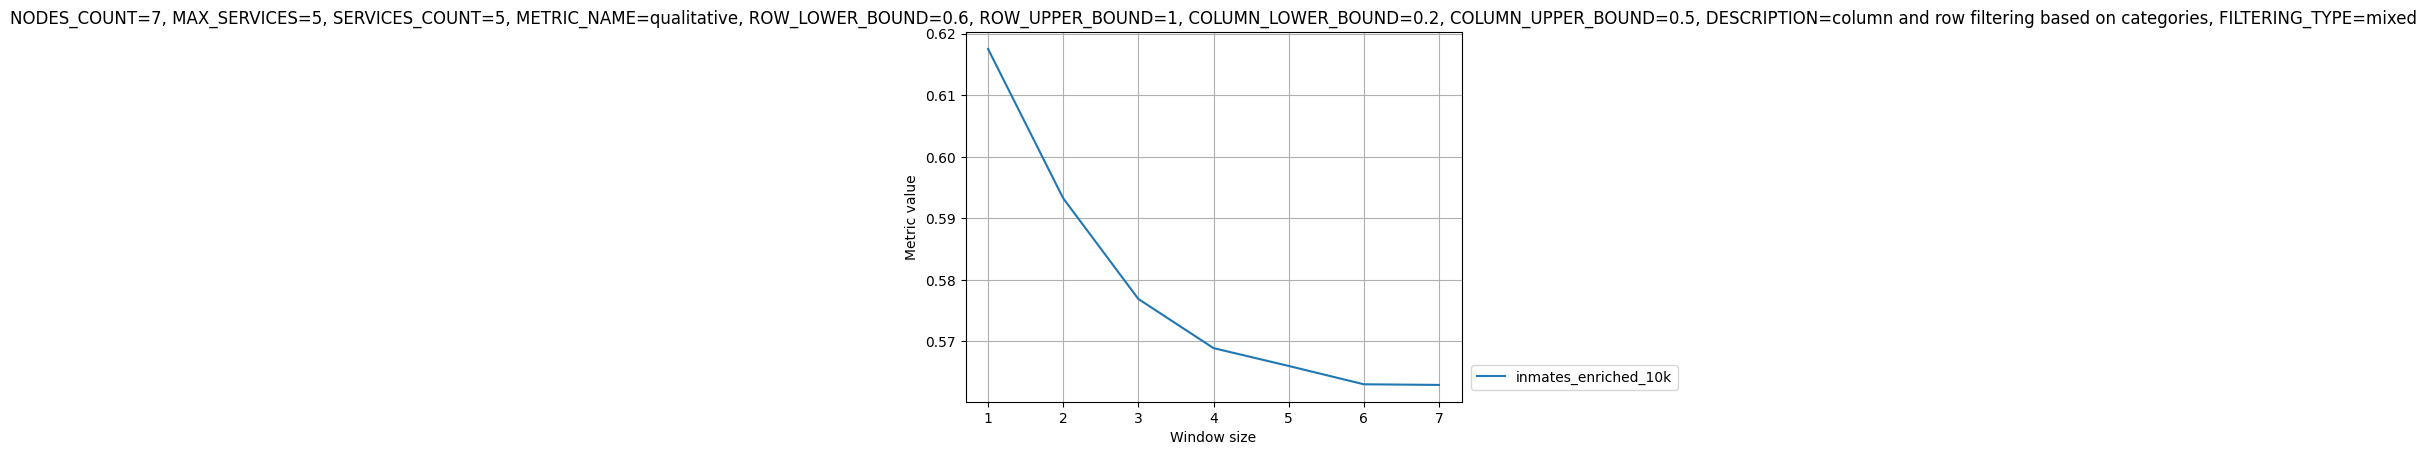

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# plt.figure(figsize=(10, 6))

for prop_value, dresults in agg_results.items():
    if len(dresults) == 0:
        continue
    ax.plot(dresults.index, dresults['metric_value'], label=prop_value)
    plt.xticks(dresults.index)

plot_title = ', '.join(map(lambda x: f'{x[0]}={x[1]}', params.items()))
ax.set_title(plot_title)
ax.set_xlabel('Window size')
ax.set_ylabel('Metric value')
ax.grid(True)
ax.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)

plt.savefig(f'agg_{COMPARE_PROP}.svg', bbox_inches = "tight")
plt.show()

## All experiments by Dataset

Results for the same experiment id are not aggregated but have their own plot

In [7]:
results_map = {}
for prop_value in prop_values:
    results_map[prop_value] = {}
    filtered_results = apply_filters_to_dataset(results, results_filters + [lambda df: df[COMPARE_PROP] == prop_value])
    experiment_ids = filtered_results['experiment_id'].unique()
    for exp_id in experiment_ids:
        exp_id_results = filtered_results[filtered_results['experiment_id'] == exp_id][['window_size', 'metric_value']].drop_duplicates()
        results_map[prop_value][exp_id] = exp_id_results

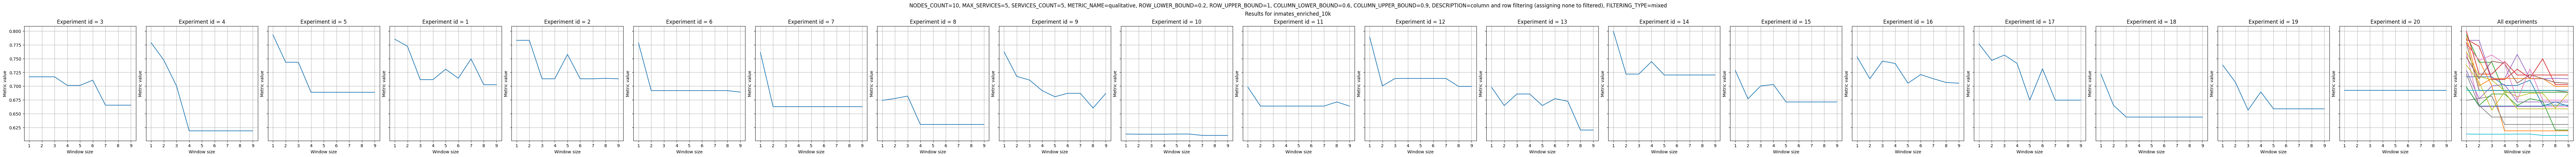

In [8]:
import matplotlib.pyplot as plt

def set_experiment_plot_properties(plot, x, y, title):
    plot.plot(x, y)
    plot.set_xlabel('Window size')
    plot.set_ylabel('Metric value')
    plot.set_title(title)
    plot.grid(True)
    plt.xticks(x)
    

results_map = {k:v for k, v in results_map.items() if len(v) > 0}
# + 1 because the first plot shows all the plot
fig_width = max(len(exp_res) + 1 for exp_res in results_map.values()) * 4

results_count = len(results_map)
fig_height = results_count * 5
fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)

plot_title = ', '.join(map(lambda x: f'{x[0]}={x[1]}', params.items()))
fig.suptitle(plot_title)

subfigs = fig.subfigures(nrows=results_count, ncols=1, squeeze=False)

for i, (prop_value, results_per_prop) in enumerate(results_map.items()):
    subfig = subfigs.item(i)
    subfig.suptitle(f'Results for {prop_value}')

    # + 1 refers to the first plot, which shows all the experiments
    axs = subfig.subplots(1, len(results_per_prop) + 1, sharex=True, sharey=True, squeeze=False)
    for exp_index, (exp_id, exp_id_results) in enumerate(results_per_prop.items()):
        set_experiment_plot_properties(axs[0][len(results_per_prop)], exp_id_results['window_size'], exp_id_results['metric_value'], f'All experiments')
        set_experiment_plot_properties(axs[0][exp_index], exp_id_results['window_size'], exp_id_results['metric_value'], f'Experiment id = {exp_id}')

#fig.tight_layout()
plt.savefig(f'all_exp_{COMPARE_PROP}.svg', bbox_inches='tight')
plt.show()